## 显存优化方案：

- 实现在4G显卡上跑Bert-large模型(hfl/chinese-macbert-large)

#### GradientAccumulation 前向激活值


In [2]:
# gradient_accumulation_steps 是一种在深度学习训练中常用的技术，用于模拟更大的批量大小，从而在有限的计算资源下提高模型的训练效果。
# 通过设置这个参数，可以在不显著增加内存需求的情况下，提高训练的稳定性和模型的性能。
from transformers import TrainingArguments
train_args = TrainingArguments(output_dir="./checkpoints",      
                               per_device_train_batch_size=1, 
                               per_device_eval_batch_size=1,   # 验证时的batch_size
                               gradient_accumulation_steps=32,   # 显存优化：每 32次迭代累积一次梯度，然后进行参数更新。
                               )


#### Gradient Checkpoints 前向激活值

In [ ]:
# gradient_checkpointing=True: 是一种用于减少深度学习模型训练过程中内存占用的技术。它通过在反向传播过程中重新计算某些中间结果，而不是存储所有中间结果，从而减少内存消耗。

train_args = TrainingArguments(output_dir="./checkpoints",      
                               per_device_train_batch_size=1,  
                               per_device_eval_batch_size=1, 
                               gradient_accumulation_steps=32,   
                               gradient_checkpointing=True,      # 显存优化：启动梯度检查点
)

#### adafactor optomizer 选择新的优化器

In [ ]:
# optim='adafactor': Adafactor 是一种自适应优化器,旨在在训练大型模型时减少内存占用，同时保持良好的训练效果。

train_args = TrainingArguments(output_dir="./checkpoints",      # 输出文件夹
                               per_device_train_batch_size=1,   # 训练时的batch_size
                               per_device_eval_batch_size=1,    # 验证时的batch_size
                               gradient_accumulation_steps=32,  
                               gradient_checkpointing=True,      
                               optim='adafactor',                # 替換优化器
)

#### Freeze model 参数冻结----Trainer

In [ ]:
from transformers import DataCollatorWithPadding


# 这段代码的作用是将 BERT 模型中的所有参数冻结（即不进行梯度更新），从而在训练过程中这些参数不会被更新
# 当你使用预训练的 BERT 模型进行微调（fine-tuning）时，通常会冻结 BERT 的底层参数，只训练顶层的分类器或其他特定任务的层。这样可以减少训练时间，并防止预训练的 BERT 模型在微调过程中过拟合到特定任务的数据。
# 如果你只是想使用 BERT 模型提取特征，而不进行微调，可以将所有参数冻结。
for name, param in model.bert.named_parameters():
    param.requires_grad = False

trainer = Trainer(model=model, 
                  args=train_args, 
                  train_dataset=tokenized_datasets["train"], 
                  eval_dataset=tokenized_datasets["test"], 
                  data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
                  compute_metrics=eval_metric)

#### 测试结果：png
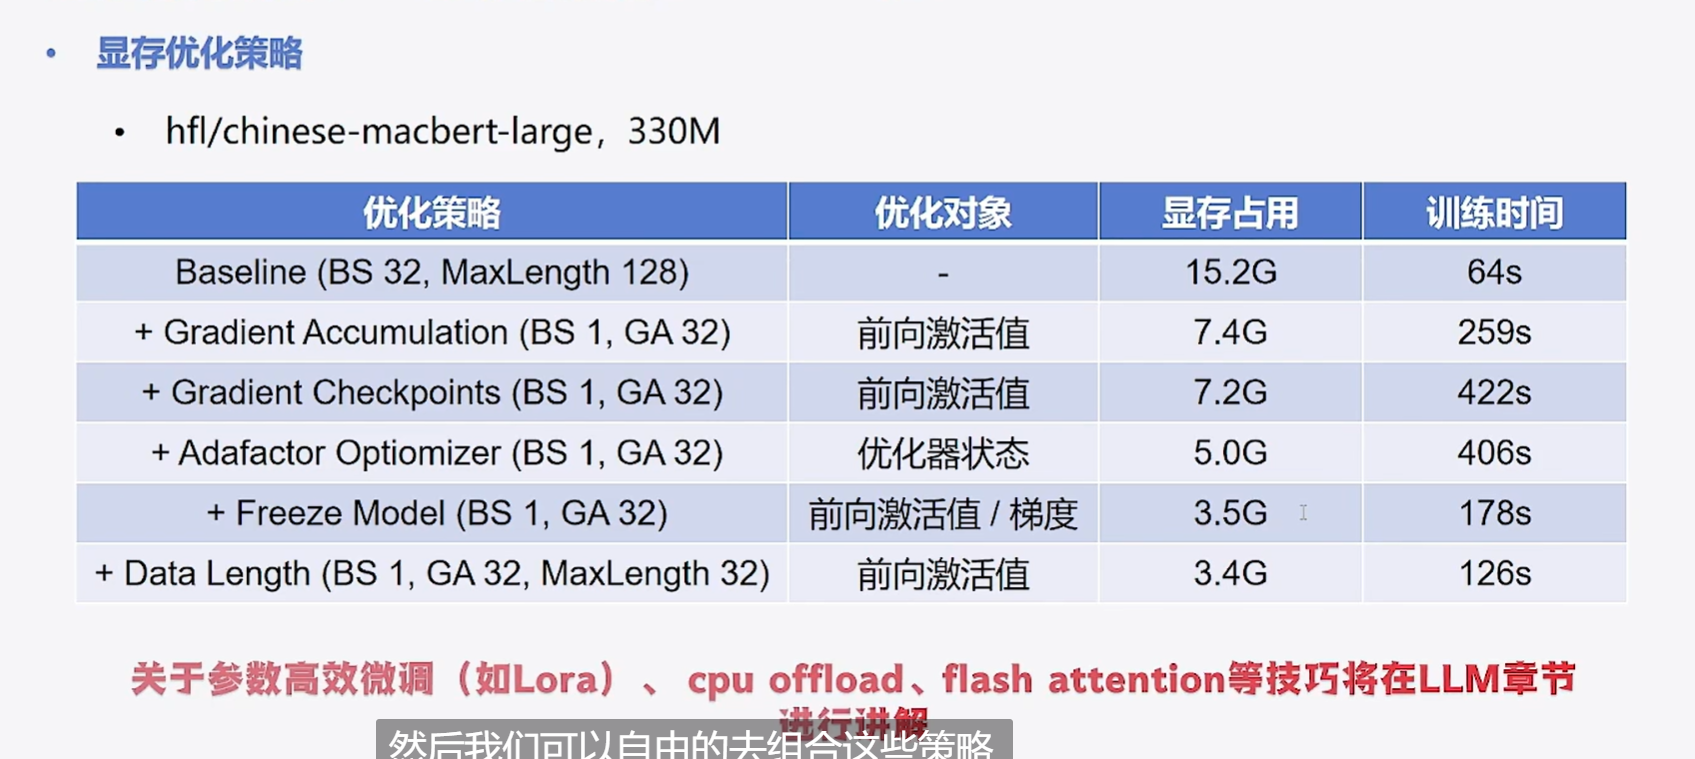